In [1]:
import nltk  # Importing the NLTK library, a powerful toolkit for natural language processing.
import string  # Importing the string library for working with strings in Python.
import re  # Importing the regular expression library for pattern matching.
import os  # Importing the os library for interacting with the operating system.
import numpy as np  # Importing NumPy for numerical operations, especially working with arrays.
import pandas as pd  # Importing Pandas for data manipulation and analysis, providing data structures like DataFrames.
import seaborn as sns  # Importing Seaborn for statistical data visualization based on Matplotlib.
import matplotlib.pyplot as plt  # Importing Matplotlib for creating various types of static, interactive, and animated visualizations in Python.
from sklearn.preprocessing import StandardScaler  # Importing StandardScaler from scikit-learn to standardize features by removing the mean and scaling to unit variance.
from sklearn.decomposition import PCA  # Importing Principal Component Analysis (PCA) from scikit-learn for dimensionality reduction techniques.
from collections import Counter  # Importing Counter from the collections library to count occurrences of items in a sequence.
from nltk.corpus import stopwords  # Importing stopwords from the NLTK corpus, which is a list of commonly used words that are often removed from text.
from nltk.stem import SnowballStemmer  # Importing SnowballStemmer from NLTK for stemming text, reducing words to their root form.
from sklearn.feature_extraction.text import CountVectorizer  # Importing CountVectorizer from scikit-learn for converting text data into a matrix of word counts.
from sklearn.model_selection import train_test_split  # Importing train_test_split from scikit-learn for splitting data into training and testing sets.
from sklearn.preprocessing import LabelEncoder  # Importing LabelEncoder from scikit-learn for converting categorical labels into numerical labels.
from sklearn.svm import SVC  # Importing Support Vector Classifier (SVC) from scikit-learn for classification tasks.
from sklearn.metrics import classification_report, balanced_accuracy_score  # Importing classification_report and balanced_accuracy_score from scikit-learn for evaluating classification models.
from sklearn.linear_model import LogisticRegression  # Importing LogisticRegression from scikit-learn for performing logistic regression.
from sklearn.tree import DecisionTreeClassifier, plot_tree  # Importing DecisionTreeClassifier and plot_tree from scikit-learn for building and visualizing decision trees.


In [2]:
#nltk.download('stopwords')

Construir Bag of Word a partir de textos

In [3]:
# Define preprocessing function
def preprocess(text, stemmer, stop_words):
    # Lowercase the input text to ensure consistent processing.
    text = text.lower()
    # Remove punctuation and numbers from the text.
    # This step helps to remove noise and improves the quality of the processed text.
    text = re.sub(r'[\d]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text into individual words or tokens.
    tokens = text.split()
    # Remove stop words and stem the remaining tokens.
    # Stop words are common words (e.g., "the", "a", "is") that are typically removed to focus on important terms.
    # Stemming reduces words to their root form.
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) >= 2]
    return ' '.join(tokens)

In [4]:
def split_into_chapters(text):
    # Split text into chapters based on "Chapter x:" headings
    chapters = []
    current_chapter = []
    for line in text.splitlines():
        # Check if the line is a chapter heading (e.g., "Chapter 1:")
        if re.match(r'^\s*Chapter\s+\d+\s*:', line, re.IGNORECASE):
            # If there's a current chapter, add it to the list of chapters
            if current_chapter:
                chapters.append('\n'.join(current_chapter))
                # Reset the current chapter
                current_chapter = []
        # Add the current line to the current chapter
        current_chapter.append(line)
    # Add the last chapter if there's any remaining content
    if current_chapter:
        chapters.append('\n'.join(current_chapter))
    return chapters


In [5]:

def process_books(directory, k, language):
    """
    Processes a directory of text files, splitting into chapters,
    applying preprocessing, retaining only the k most common words,
    and returning a CountVectorizer object.

    Args:
        directory: Path to the directory with .txt files.
        k: Number of most common words to retain.
        language: Language for stemming and stopwords.

    Returns:
        A tuple (X, vectorizer, chapter_ids) where:
        - X is the matrix representation (chapters x words),
        - vectorizer is the fitted CountVectorizer,
        - chapter_ids is a list like ["book1_chapter1", "book1_chapter2", ...]
    """
    all_texts = []
    chapter_ids = []

    stemmer = SnowballStemmer(language)
    stop_words = set(stopwords.words(language))
    
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding='utf-8') as f:
                text = f.read()
                chapters = split_into_chapters(text)
                for idx, chapter in enumerate(chapters, 1):
                    processed_chapter = preprocess(chapter, stemmer, stop_words)
                    all_texts.append(processed_chapter)
                    chapter_ids.append(f"{filename[:-4]}_chapter{idx}")

    # Build vocabulary of the k most common words
    all_word_list = [word for text in all_texts for word in text.split()]
    most_common_words = [word for word, _ in Counter(all_word_list).most_common(k)]

    # Vectorize
    vectorizer = CountVectorizer(min_df=1, vocabulary=most_common_words)
    X = vectorizer.fit_transform(all_texts)
    
    return X, vectorizer, chapter_ids


In [6]:
X, vectorizer, books = process_books('./books',100,"english")

In [7]:
# Load titles
titulos_df = pd.read_csv('./titulos.csv')

# Create mapping: filename -> title, author
book_mapping = dict(zip(titulos_df['title'], titulos_df['author']))

# Build a DataFrame for chapters
chapter_df = pd.DataFrame({
    'chapter_id': books,   # e.g., 'book1_chapter1'
    'text': list(X.toarray())
})

# Extract book name from chapter_id
chapter_df['book_name'] = chapter_df['chapter_id'].apply(lambda x: re.sub(r'_chapter\d+$', '', x))

# Now map title and author
chapter_df['title'] = chapter_df['book_name']
chapter_df['author'] = chapter_df['title'].map(book_mapping)

# Expand the X matrix into columns
X_dense = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Merge chapter information
df_books_full = pd.concat([chapter_df[['title', 'author']], X_dense], axis=1)


In [8]:
# Create a LabelEncoder object to convert categorical author names into numerical values.
label_encoder = LabelEncoder()
# Fit the LabelEncoder to the 'author' column of the DataFrame and transform it into numerical values.
# These numerical values are then stored in the 'y' variable.
y = label_encoder.fit_transform(df_books_full['author'])
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.4, random_state=42)

In [9]:
# Scale the data to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)

# Perform Principal Component Analysis (PCA) to reduce data to 2 dimensions
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

<function matplotlib.pyplot.show(close=None, block=None)>

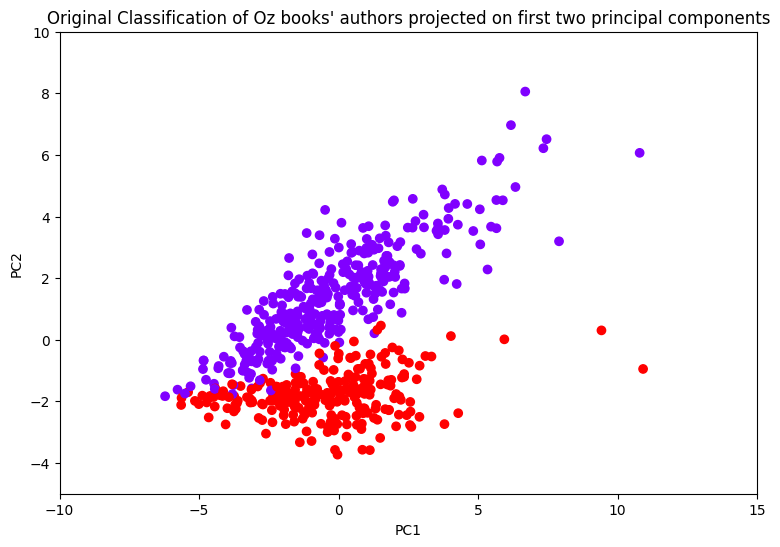

In [ ]:
# Create a scatter plot of the data in the first two principal components.
# The color of each point is determined by the corresponding class label.
plt.figure(figsize=(9,6))
plt.scatter(pca_data[:,0],pca_data[:,1], c = y, cmap = 'rainbow')
plt.xlim(-10, 15)
plt.ylim(-5,10)
# Add a title to the plot.
plt.title('Original Classification of Oz books\' authors projected on first two principal components')
# Label the x-axis as "PC1" (first principal component)
plt.xlabel("PC{}".format(1))
# Label the y-axis as "PC2" (second principal component)
plt.ylabel("PC{}".format(2))
# Display the plot
plt.show()

In [11]:
# This line trains the Support Vector Machine (SVM) classifier using the training data.
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train, y_train)

# This line makes predictions on the complete dataset using the trained SVM classifier.
# The predicted labels are stored in the variable 'y_svm'.
y_svm = svm_classifier.predict(X_dense)

In [ ]:
# This code prints the SVM classification report for the Oz books dataset.
print("Support Vector Machine classification of Oz books' author report:")
print(classification_report(y, y_svm, target_names=label_encoder.classes_))

Oz books' author SVM classification report:
                      precision    recall  f1-score   support

       L. Frank Baum       0.99      0.99      0.99       342
Ruth Plumly Thompson       0.99      0.99      0.99       252

            accuracy                           0.99       594
           macro avg       0.99      0.99      0.99       594
        weighted avg       0.99      0.99      0.99       594



<function matplotlib.pyplot.show(close=None, block=None)>

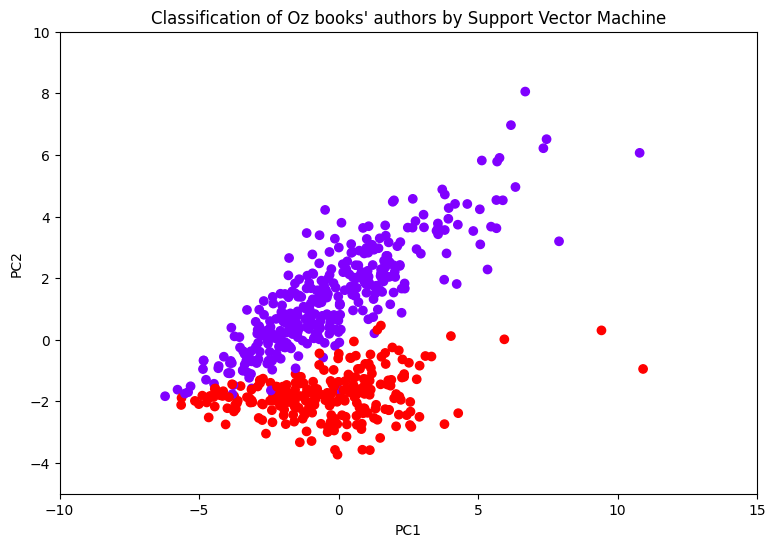

In [ ]:
# This code generates a scatter plot of the first two principal components of the PCA data, colored by the predicted class labels from the SVM model.
plt.figure(figsize=(9,6))
# Generate a scatter plot with PC1 on the x-axis and PC2 on the y-axis.
plt.scatter(pca_data[:,0],pca_data[:,1], c = y_svm, cmap = 'rainbow')
# Set the x-axis limits for better visualization.
plt.xlim(-10, 15)
# Set the y-axis limits for better visualization.
plt.ylim(-5,10)
# Add a title to the plot.
plt.title('Classification of Oz books\' authors by Support Vector Machine')
# Add an x-axis label.
plt.xlabel("PC{}".format(1))
# Add a y-axis label.
plt.ylabel("PC{}".format(2))
# Display the plot.
plt.show()

In [14]:
# This line trains the Logistic Regression model using the training data.
# max_iter = 1000 sets the maximum number of iterations for the optimization algorithm.
# solver='newton-cg' specifies the solver to be used, in this case, Newton-Conjugate Gradient.
# penalty = 'l2' applies L2 regularization to the model, preventing overfitting.
# C = 0.5 sets the regularization strength.
lr_classifier = LogisticRegression(max_iter = 1000, solver='newton-cg', penalty = 'l2', C = 0.5)
lr_classifier.fit(X_train, y_train)

# Make predictions on the test set
# This line makes predictions on the dataset using the trained Logistic Regression model.
y_lr = lr_classifier.predict(X_dense)


In [ ]:
print("Logistic Regression classification of Oz books' author report:")
print(classification_report(y, y_lr, target_names=label_encoder.classes_))


Oz books' author LR classification report:
                      precision    recall  f1-score   support

       L. Frank Baum       0.99      1.00      1.00       342
Ruth Plumly Thompson       1.00      0.99      0.99       252

            accuracy                           0.99       594
           macro avg       1.00      0.99      0.99       594
        weighted avg       0.99      0.99      0.99       594



<function matplotlib.pyplot.show(close=None, block=None)>

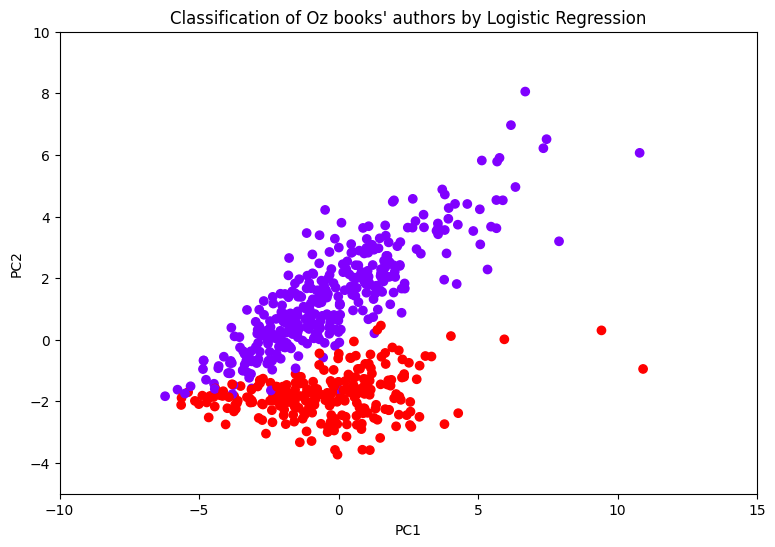

In [ ]:
# This code generates a scatter plot to visualize the classification of Oz books' authors using logistic regression.
plt.figure(figsize=(9,6))
# Creates a new figure with a specified size (width=9 inches, height=6 inches).
plt.scatter(pca_data[:,0],pca_data[:,1], c = y_lr, cmap = 'rainbow')
# Creates a scatter plot with two dimensions of the principal component data (PC1 and PC2) as x and y coordinates.
# The color of each point is determined by the predicted class labels (y_lr) using the 'rainbow' colormap.
plt.xlim(-10, 15)
# Sets the x-axis limits to range from -10 to 15.
plt.ylim(-5,10)
# Sets the y-axis limits to range from -5 to 10.
plt.title('Classification of Oz books\' authors by Logistic Regression')
# Sets the title of the plot.
plt.xlabel("PC{}".format(1))
# Sets the label for the x-axis.
plt.ylabel("PC{}".format(2))
# Sets the label for the y-axis.
plt.show()

In [17]:
# Train decision tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Find optimal ccp_alpha for pruning by obtaining cost complexity path
path = clf.cost_complexity_pruning_path(X_train, y_train)
# Extract ccp_alphas excluding max alpha which prunes everything
ccp_alphas = path.ccp_alphas[:-1]

# Train Decision Trees with different ccp_alpha values
# This will evaluate the effect of pruning on model performance
clfs = [DecisionTreeClassifier(ccp_alpha=alpha, random_state=42).fit(X_train, y_train) for alpha in ccp_alphas]

# Compute balanced accuracy scores for both training and test sets
train_scores = [balanced_accuracy_score(y_train, clf.predict(X_train)) for clf in clfs]
test_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

# Select best alpha (where test accuracy is maximized)
best_alpha = ccp_alphas[np.argmax(test_scores)]
print(f"Optimal ccp_alpha: {best_alpha:.6f}")

# Train pruned decision tree
clf_pruned = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)

Optimal ccp_alpha: 0.009804


In [ ]:
# This line trains the pruned classification model on the training data.
clf_pruned.fit(X_train, y_train)
# Predicti on the dataset using the trained pruned classifier.
y_clf = clf_pruned.predict(X_dense)

In [ ]:
print("Decision Tree classification of Oz books' author report:")
print(classification_report(y, y_clf, target_names=label_encoder.classes_))


Oz books' author SVM classification report:
                      precision    recall  f1-score   support

       L. Frank Baum       0.95      0.93      0.94       342
Ruth Plumly Thompson       0.91      0.94      0.92       252

            accuracy                           0.93       594
           macro avg       0.93      0.94      0.93       594
        weighted avg       0.94      0.93      0.93       594



<function matplotlib.pyplot.show(close=None, block=None)>

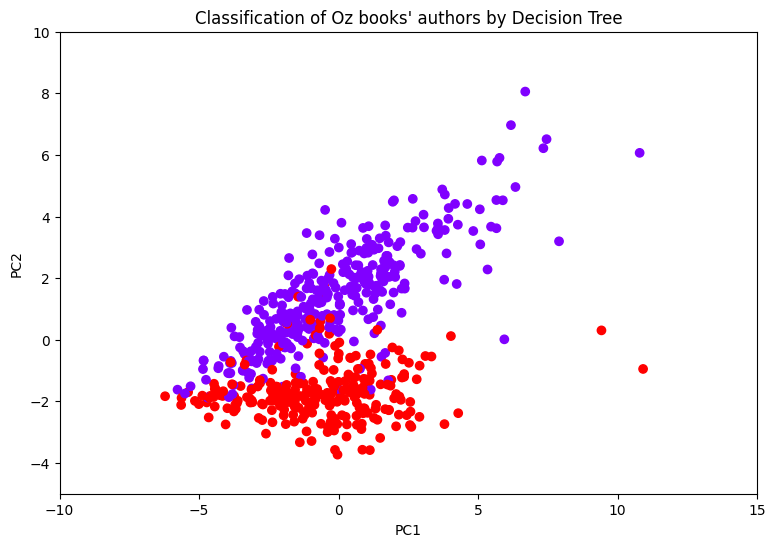

In [ ]:
import matplotlib.pyplot as plt
# This line imports the matplotlib.pyplot module, which is used for creating plots.
plt.figure(figsize=(9,6))
# This line creates a new figure object with a specified size (width=9 inches, height=6 inches).
plt.scatter(pca_data[:,0],pca_data[:,1], c = y_clf, cmap = 'rainbow')
# This line creates a scatter plot using the principal component data (pca_data) along with the class labels (y_clf) and a rainbow color map.
plt.xlim(-10, 15)
# This line sets the x-axis limits of the plot to be between -10 and 15.
plt.ylim(-5,10)
# This line sets the y-axis limits of the plot to be between -5 and 10.
plt.title('Classification of Oz books\' authors by Decision Tree')
# This line sets the title of the plot to " Classification of Oz books\' authors".
# This line sets the title of the plot to " Classification of Oz books\' authors".
# This line sets the x-axis label of the plot to "PC{}".format(1), where PC1 is the first principal component.
plt.xlabel("PC{}".format(1))
# This line sets the y-axis label of the plot to "PC{}".format(2), where PC2 is the second principal component.
# This line sets the x-axis label of the plot to "PC{}".format(1), where PC1 is the first principal component.
plt.ylabel("PC{}".format(2))
# This line sets the y-axis label of the plot to "PC{}".format(2), where PC2 is the second principal component.
plt.show()